In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train"
new_test = "./new_val_in/new_val_in"



# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)
val_testset  = ArgoverseDataset(data_path=new_test)

In [3]:
batch_sz = 4
batch_sz_test = 1
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=0)


In [88]:
def my_collate1(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    scene_idx = [numpy.dstack([scene['scene_idx']]) for scene in batch]
    inp = torch.FloatTensor(inp)
    return scene_idx, inp

test_loader = DataLoader(val_testset, batch_size=batch_sz_test, shuffle=False, collate_fn=my_collate1)

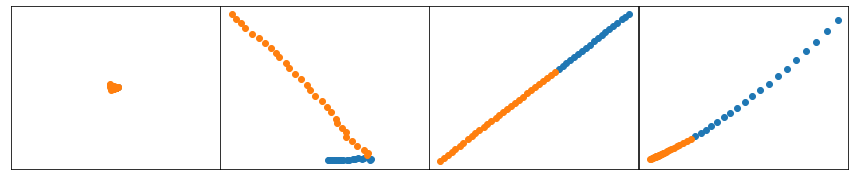

In [46]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    show_sample_batch(sample_batch, agent_id)
    break

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class FCModule(nn.Module):
    
    def __init__(self):
        super(FCModule, self).__init__()
        
        self.hidden_dim = 8192
        self.linear2 = nn.Sequential(nn.Linear(240*19, self.hidden_dim), nn.ReLU(), nn.Linear(self.hidden_dim, 240*30))
        
        

    def forward(self, x):
        
        x = self.linear2(x)
        
        return x
    
    def forward_test(self, x, num_steps = 30):
        res=[]
        h = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        c = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        for step in range(num_steps):
            x, (h,c) = self.lstm(x, (h,c))
            x = x[:,-1:]
            x = x.transpose(1,2)
            x = self.linear(x)
            x = x.transpose(1,2)
            res.append(x)
        res = torch.cat(res,1)
        return res

In [7]:
from tqdm import tqdm_notebook as tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda:0"
model = FCModule().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

loss_ema = -1
loss_ema2 = -1

for epoch in range(10):
    for i_batch, sample_batch in enumerate (val_loader):
        inp,out = sample_batch
        inp = inp.cuda()
        out = out.cuda()
        mixed = torch.cat([inp,out],2).transpose(1,2).reshape(-1,49,240)
        y_pred = model(inp.reshape(len(inp),-1)).reshape(-1,60,30,4)
        loss = (torch.mean((y_pred-out)**2))**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss_ema < 0:
            loss_ema = loss
        loss_ema = loss_ema*0.99 + loss*0.01
        
        if i_batch%10 == 0:
            print('loss full', epoch, i_batch, loss_ema.item(), loss.item())
torch.save(model.state_dict(),"usingSequential")

loss full 0 0 745.22900390625 745.22900390625


KeyboardInterrupt: 

In [118]:
import csv
import pandas as pd
import numpy as np
import gc

gc.collect()

torch.cuda.empty_cache()

device = "cuda:0"
model = FCModule().to(device)
model.load_state_dict(torch.load("fully_conn_output"))

filename = "output_test.csv"

def test(model, device, test_loader):
    model.eval()
    store = [[]]
    strArr = []
    strArr.append('ID')
    for i in range(60):
        strArr.append('v' + str(i + 1))
    

    with torch.no_grad():
        for scene_idx, data in test_loader:
            data = data.to(device)
            y_pred = model(data.reshape(len(data),-1)).reshape(-1,60,30,4)
            y_pred = y_pred[-1,0,:,0:2]
            y_pred = y_pred.cpu()
            y_pred_np = y_pred.numpy()
            y_pred_np = y_pred_np.flatten()
            y_pred_np = np.insert(y_pred_np, 0, scene_idx[0][0][0][0])
            store.append(y_pred_np)
            
            

    with open(filename, 'w',  newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(strArr) 
        csvwriter.writerows(store)

test(model, device, test_loader)